In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from medmnist import ChestMNIST
from sklearn.metrics import roc_auc_score

In [2]:
# Parameters
BATCH_SIZE = 64
NUM_EPOCHS = 50
PATIENCE = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Dataset loaders
train_dataset = ChestMNIST(split='train', transform=transform, download=True, size=64)
val_dataset = ChestMNIST(split='val', transform=transform, download=True, size=64)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [4]:
# Model
class ChestMNISTMultiLabelCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 14)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)  # No sigmoid here

# Initialize
model = ChestMNISTMultiLabelCNN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

In [7]:
# Early stopping setup
best_val_loss = float('inf')
epochs_no_improve = 0
# Training loop
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE).float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    avg_train_loss = running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(DEVICE)
            targets = targets.to(DEVICE).float()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
    avg_val_loss = val_loss / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "pneumonia_classifier.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

Epoch 1/50 - Train Loss: 0.1717 - Val Loss: 0.1720
Epoch 2/50 - Train Loss: 0.1685 - Val Loss: 0.1683
Epoch 3/50 - Train Loss: 0.1653 - Val Loss: 0.1660
Epoch 4/50 - Train Loss: 0.1623 - Val Loss: 0.1652
Epoch 5/50 - Train Loss: 0.1592 - Val Loss: 0.1657
Epoch 6/50 - Train Loss: 0.1559 - Val Loss: 0.1663
Epoch 7/50 - Train Loss: 0.1524 - Val Loss: 0.1677
Epoch 8/50 - Train Loss: 0.1482 - Val Loss: 0.1723
Epoch 9/50 - Train Loss: 0.1440 - Val Loss: 0.1731
Early stopping triggered.


In [5]:
model.load_state_dict(torch.load("pneumonia_classifier.pth"))
model.eval()
pneumonia_probs = []
pneumonia_labels = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        outputs = torch.sigmoid(model(inputs))
        pneumonia_probs.extend(outputs[:, 6].cpu().numpy())
        pneumonia_labels.extend(targets[:, 6].cpu().numpy())

auc = roc_auc_score(pneumonia_labels, pneumonia_probs)
print(f"Pneumonia AUC on val: {auc:.3f}")


Pneumonia AUC on val: 0.705


In [6]:
import torch
from torchvision import transforms
from medmnist import ChestMNIST
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Constants
IMG_SIZE = 64
PNEUMONIA_LABEL = 6
MAX_REAL_IMAGES = 1000  # you can reduce this for speed

# Transform: keep [0,1] range
transform = transforms.Compose([
    transforms.ToTensor()
])

# Dataset wrapper to get only pneumonia images
class PneumoniaDataset(Dataset):
    def __init__(self, base_dataset, label_index=6):
        self.base_dataset = base_dataset
        self.indices = [i for i in range(len(base_dataset)) if int(base_dataset[i][1][label_index]) == 1]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, _ = self.base_dataset[self.indices[idx]]
        return img.squeeze(0).numpy()  # shape: (64, 64)

# Load data
full_dataset = ChestMNIST(split='train', transform=transform, download=True, size=IMG_SIZE)
pneumonia_dataset = PneumoniaDataset(full_dataset, label_index=PNEUMONIA_LABEL)
pneumonia_loader = DataLoader(pneumonia_dataset, batch_size=64, shuffle=False)

# Collect up to N real pneumonia images
real_pneumonia_images = []
for batch in pneumonia_loader:
    for img in batch:
        real_pneumonia_images.append(img)
        if len(real_pneumonia_images) >= MAX_REAL_IMAGES:
            break
    if len(real_pneumonia_images) >= MAX_REAL_IMAGES:
        break

print(f"✅ Collected {len(real_pneumonia_images)} real pneumonia images.")


✅ Collected 978 real pneumonia images.


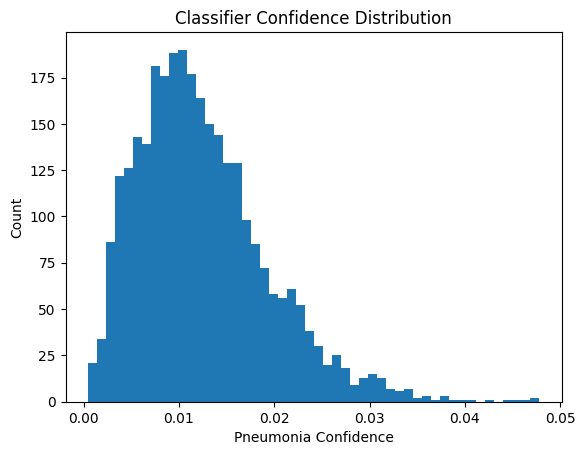

Images passing confidence threshold: 0


In [13]:
import matplotlib.pyplot as plt
confidences = []
model.eval()
with torch.no_grad():
    for img_np, fname in top_ssim_images:
        tensor_img = torch.tensor(img_np).unsqueeze(0).unsqueeze(0).to(DEVICE)
        prob = torch.sigmoid(model(tensor_img))[0, 6].item()
        confidences.append(prob)

plt.hist(confidences, bins=50)
plt.title("Classifier Confidence Distribution")
plt.xlabel("Pneumonia Confidence")
plt.ylabel("Count")
plt.show()

print("Images passing confidence threshold:", sum([c >= CONFIDENCE_THRESHOLD for c in confidences]))


In [7]:
import os
import torch
import imageio
import numpy as np
from torchvision import transforms
from PIL import Image

# Paths
input_folder = 'augmented/pneumonia'
output_folder = 'filtered_confidence_500/pneumonia'
os.makedirs(output_folder, exist_ok=True)

# Load classifier
model.eval()

# Transform for input
transform = transforms.ToTensor()  # keeps input in [0, 1]


# Collect confidences
confidences = []
image_data = []

for fname in os.listdir(input_folder):
    if not fname.endswith('.png'):
        continue

    path = os.path.join(input_folder, fname)
    img = Image.open(path).convert("L")
    img_tensor = transform(img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        prob = torch.sigmoid(model(img_tensor))[0, 6].item()  # pneumonia index

    confidences.append(prob)
    image_data.append((np.array(img), fname))

# Sort and save top 1000
sorted_images = sorted(zip(confidences, image_data), key=lambda x: x[0], reverse=True)
top_images = sorted_images[:500]

for i, (conf, (img_np, fname)) in enumerate(top_images):
    save_path = os.path.join(output_folder, f"{i:04d}_{conf:.3f}.png")
    imageio.imwrite(save_path, img_np)

print(f"✅ Saved top {len(top_images)} confident images to '{output_folder}'")


✅ Saved top 500 confident images to 'filtered_confidence_500/pneumonia'
